# Deep Neural Network from Scratch on the Moons Dataset
This notebook implements a multi-layer perceptron without high-level libraries to classify the synthetic 'moons' dataset. We cover:

- Data generation and visualization
- Network architecture and weight initialization
- Feedforward propagation
- Mean squared error cost and backpropagation
- Training via stochastic gradient descent with tracking of cost and accuracy
- Decision boundary visualization
- Discussion of results


In [11]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
sns.set_theme()


## Data Generation & Initial Visualization
We generate 1,000 samples from the two-moons dataset with noise and plot the raw data.

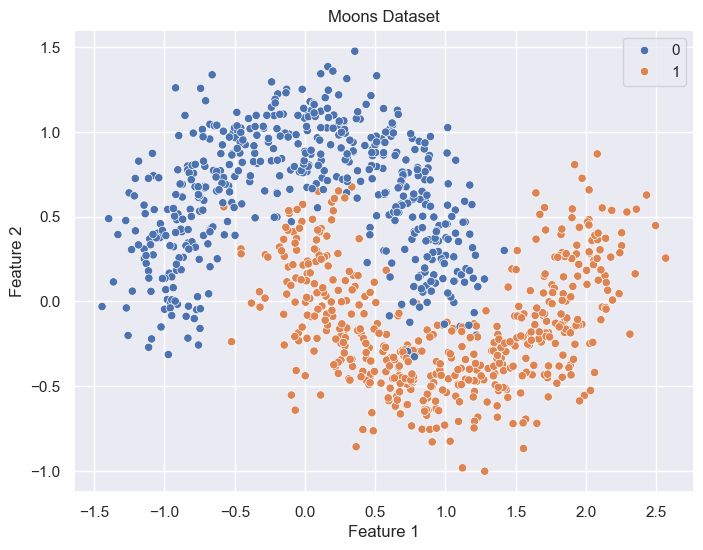

In [12]:
# Generate moons dataset
X, y = make_moons(n_samples=1000, noise=0.2, random_state=42)
# Plot
plt.figure(figsize=(8,6))
sns.scatterplot(x=X[:,0], y=X[:,1], hue=y, palette='deep')
plt.title('Moons Dataset')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

## Preprocessing
1. **Standardize** features to zero mean/unit variance:
$$X_{\text{std}} = \frac{X - \mu}{\sigma}$$
2. **One-hot encode** labels into two dimensions
3. **Train/test split** (80% train, 20% test)

In [13]:
# Standardize
X_mean = X.mean(axis=0)
X_std = X.std(axis=0)
X_std = (X - X_mean) / X_std

# One-hot encode
y_oh = np.zeros((y.size, 2))
y_oh[np.arange(y.size), y] = 1

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_std, y_oh, test_size=0.2, random_state=42, stratify=y)

print('Train samples:', X_train.shape[0], 'Test samples:', X_test.shape[0])

Train samples: 800 Test samples: 200


## How Deep Neural Networks Work for Classification

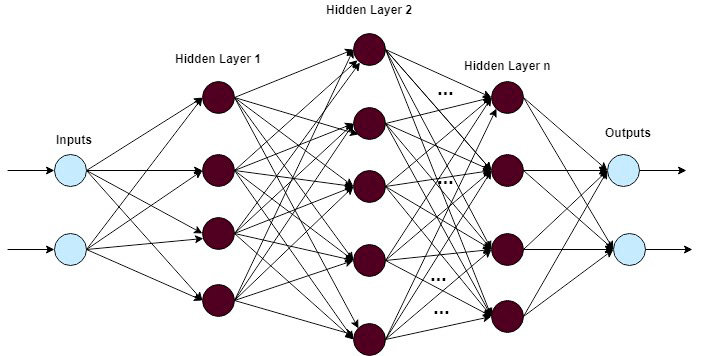

A deep neural network (DNN) is an **iterative function approximator** built by stacking layers of simple “neurons” (units) to learn complex, highly non-linear decision boundaries. Here’s an outline of the key ideas:

1. **Network Architecture**  
   - Consists of an **input layer**, one or more **hidden layers**, and an **output layer**.  
   - Each hidden layer $\ell$ has weight matrix $\mathbf{W}^{(\ell)}$ and bias vector $\mathbf{b}^{(\ell)}$.  
   - For $L$ hidden layers and a $C$-class problem, the output layer size is $C$.

2. **Forward Pass**  
   - Given an input $\mathbf{x}$, compute pre-activation at layer $\ell$:
     $$
       \mathbf{z}^{(\ell)}
       = \mathbf{W}^{(\ell)}\,\mathbf{a}^{(\ell-1)} + \mathbf{b}^{(\ell)}, 
       \quad \mathbf{a}^{(0)} = \mathbf{x}.
     $$
   - Apply an **activation function** $\sigma$:
     $$
       \mathbf{a}^{(\ell)} = \sigma\bigl(\mathbf{z}^{(\ell)}\bigr),
       \quad \sigma \in \{\mathrm{ReLU},\,\tanh,\,\mathrm{sigmoid},\dots\}.
     $$
   - At the output layer, use **softmax** to produce class probabilities:
     $$
       \hat p_c
       = \frac{\exp\!\bigl(z_c^{(L+1)}\bigr)}
              {\sum_{k=1}^C \exp\!\bigl(z_k^{(L+1)}\bigr)}.
     $$

3. **Loss Function**  
   - For one‐hot labels $\mathbf{y}\in\{0,1\}^C$, use **cross‐entropy**:
     $$
       \mathcal{L}(\hat{\mathbf{p}},\mathbf{y})
       = -\sum_{c=1}^C y_c \,\log \hat p_c.
     $$
   - The total loss over $N$ examples is
     $$
       \frac{1}{N}\sum_{i=1}^N
         \mathcal{L}\bigl(\hat{\mathbf{p}}^{(i)},\,\mathbf{y}^{(i)}\bigr).
     $$

4. **Backward Pass (Backpropagation)**  
   - Compute gradients of the loss w.r.t. each parameter via the chain rule.  
   - At the output layer:
     $$
       \frac{\partial \mathcal{L}}{\partial z_c^{(L+1)}}
       = \hat p_c - y_c.
     $$
   - At hidden layers $\ell$:
     $$
       \delta^{(\ell)}
       = \frac{\partial \mathcal{L}}{\partial \mathbf{z}^{(\ell)}} 
       = \bigl(\mathbf{W}^{(\ell+1)\,T}\,\delta^{(\ell+1)}\bigr)
         \,\odot\,\sigma'\bigl(\mathbf{z}^{(\ell)}\bigr).
     $$
   - Parameter gradients:
     $$
       \frac{\partial \mathcal{L}}{\partial \mathbf{W}^{(\ell)}}
       = \delta^{(\ell)}\,\mathbf{a}^{(\ell-1)\,T},
       \quad
       \frac{\partial \mathcal{L}}{\partial \mathbf{b}^{(\ell)}}
       = \delta^{(\ell)}.
     $$

5. **Parameter Update (Gradient Descent)**  
   - Using learning rate $\eta$, update weights and biases:
     $$
       \mathbf{W}^{(\ell)} 
       \;\gets\; \mathbf{W}^{(\ell)} - \eta\,
       \frac{\partial \mathcal{L}}{\partial \mathbf{W}^{(\ell)}},
       \quad
       \mathbf{b}^{(\ell)}
       \;\gets\; \mathbf{b}^{(\ell)} - \eta\,
       \frac{\partial \mathcal{L}}{\partial \mathbf{b}^{(\ell)}}.
     $$
   - Variants include **stochastic**, **mini-batch**, with optimizers like **Adam**.

6. **Prediction**  
   - After training, classify a new input $\mathbf{x}$ by forward-passing through the network and taking
     $$
       \arg\max_{c}\,\hat p_c.
     $$

## `DenseNetwork` Class Definition
Implements initialization, feedforward, backpropagation, and SGD with tracking.

In [ ]:
class DenseNetwork:
    def __init__(self, sizes):
        self.sizes = sizes
        self.num_layers = len(sizes)
        self.biases = [np.random.randn(n, 1) for n in sizes[1:]]
        self.weights = [np.random.randn(n, m)/np.sqrt(m)
                        for m, n in zip(sizes[:-1], sizes[1:])]
        
    @staticmethod
    def sigmoid(z):
        return 1/(1+np.exp(-z))
    
    @staticmethod
    def sigmoid_prime(z):
        s = 1/(1+np.exp(-z))
        return s*(1-s)
    
    def feedforward(self, a):
        for b, w in zip(self.biases, self.weights):
            a = DenseNetwork.sigmoid(w @ a + b)
        return a
    
    def backprop(self, x, y):
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        activation = x.reshape(-1,1)
        activations = [activation]
        zs = []

        # feedforward
        for b, w in zip(self.biases, self.weights):
            z = w @ activation + b
            zs.append(z)
            activation = DenseNetwork.sigmoid(z)
            activations.append(activation)

        # backward pass
        delta = (activations[-1] - y.reshape(-1,1)) * DenseNetwork.sigmoid_prime(zs[-1])
        nabla_b[-1] = delta
        nabla_w[-1] = delta @ activations[-2].T
        for l in range(2, self.num_layers):
            z = zs[-l]
            sp = DenseNetwork.sigmoid_prime(z)
            delta = (self.weights[-l+1].T @ delta) * sp
            nabla_b[-l] = delta
            nabla_w[-l] = delta @ activations[-l-1].T
        return nabla_b, nabla_w
    
    def SGD(self, training_data, epochs, eta, test_data=None):
        n = len(training_data)
        self.cost_history = []
        self.train_acc = []
        self.test_acc = []
        for j in range(epochs):
            np.random.shuffle(training_data)
            for x, y in training_data:
                nabla_b, nabla_w = self.backprop(x, y)
                self.weights = [w - eta*nw for w, nw in zip(self.weights, nabla_w)]
                self.biases  = [b - eta*nb for b, nb in zip(self.biases,  nabla_b)]

            # record cost
            cost = 0.5*sum(np.linalg.norm(self.feedforward(x.reshape(-1,1)) - y.reshape(-1,1))**2 \
                           for x, y in training_data)/n
            self.cost_history.append(cost)

            # train acc
            train_preds = [np.argmax(self.feedforward(x.reshape(-1,1))) for x,y in training_data]
            train_labels= [np.argmax(y) for x,y in training_data]
            acc_train = sum(p==t for p,t in zip(train_preds,train_labels))/n
            self.train_acc.append(acc_train)

            # test acc
            if test_data:
                m = len(test_data)
                test_preds = [np.argmax(self.feedforward(x.reshape(-1,1))) for x,y in test_data]
                test_labels= [np.argmax(y) for x,y in test_data]
                acc_test = sum(p==t for p,t in zip(test_preds,test_labels))/m
                self.test_acc.append(acc_test)
            print(f"Epoch {j+1}: cost={cost:.4f}, train acc={acc_train:.3f}" \
                  + (f", test acc={acc_test:.3f}" if test_data else ""))
        return self
    
    def evaluate(self, data):
        preds = [(np.argmax(self.feedforward(x.reshape(-1,1))), np.argmax(y)) for x,y in data]
        return sum(int(p==t) for p,t in preds)


In [15]:
# Helper functions for Random Experiment
def compute_MSE(net, data):
    """Compute mean squared error for a DenseNetwork on given data list of (x,y_onehot)."""
    errors = []
    for x, y in data:
        y_pred = net.feedforward(x.reshape(-1,1))
        errors.append(np.sum((y_pred - y.reshape(-1,1))**2))
    return np.mean(errors)

def random_experiment(network_class, sizes, data, runs=5):
    """Run random initializations and report MSEs."""
    results = []
    for i in range(runs):
        net_rand = network_class(sizes)
        mse = compute_MSE(net_rand, data)
        results.append(mse)
    print(f"Random initialization MSEs over {runs} runs: {results}")


## Prepare Training & Test Data for SGD
We zip the arrays into lists of tuples and include test data for evaluation.

In [16]:
train_data = list(zip(X_train, y_train))
test_data  = list(zip(X_test,  y_test))

## Training with SGD
Train for 50 epochs with learning rate η=1.0 and track performance.

In [17]:
net = DenseNetwork([2, 60, 60, 2])
net.SGD(train_data, epochs=50, eta=1.0, test_data=test_data)

Epoch 1: cost=0.0989, train acc=0.860, test acc=0.925
Epoch 2: cost=0.0972, train acc=0.851, test acc=0.920
Epoch 3: cost=0.0953, train acc=0.859, test acc=0.925
Epoch 4: cost=0.0796, train acc=0.884, test acc=0.925
Epoch 5: cost=0.0661, train acc=0.909, test acc=0.955
Epoch 6: cost=0.0354, train acc=0.958, test acc=0.970
Epoch 7: cost=0.0416, train acc=0.944, test acc=0.975
Epoch 8: cost=0.0360, train acc=0.950, test acc=0.970
Epoch 9: cost=0.0439, train acc=0.938, test acc=0.970
Epoch 10: cost=0.0290, train acc=0.966, test acc=0.975
Epoch 11: cost=0.0257, train acc=0.965, test acc=0.995
Epoch 12: cost=0.0261, train acc=0.964, test acc=0.985
Epoch 13: cost=0.0345, train acc=0.951, test acc=0.970
Epoch 14: cost=0.0312, train acc=0.956, test acc=0.975
Epoch 15: cost=0.0391, train acc=0.950, test acc=0.955
Epoch 16: cost=0.0274, train acc=0.965, test acc=0.975
Epoch 17: cost=0.0239, train acc=0.965, test acc=0.990
Epoch 18: cost=0.0293, train acc=0.964, test acc=0.985
Epoch 19: cost=0.03

## Loss and Accuracy Curves
Plot the training cost, training accuracy, and test accuracy over epochs.

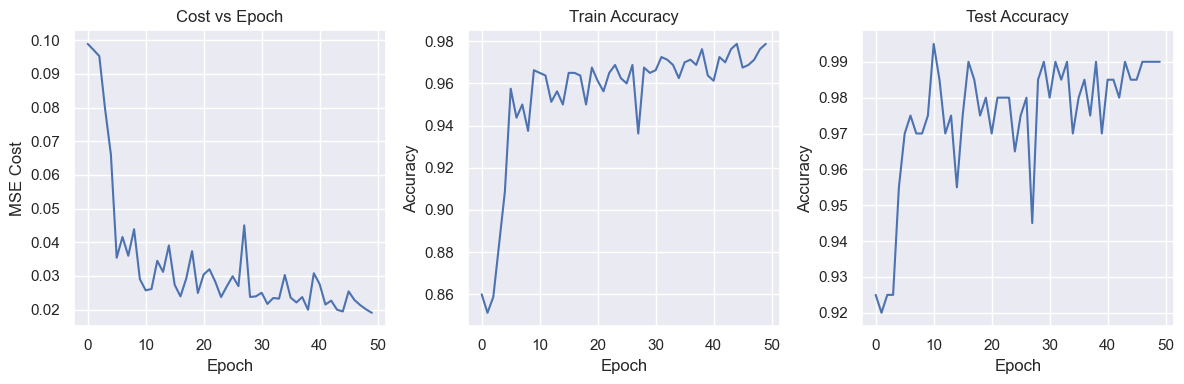

In [18]:
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.plot(net.cost_history)
plt.title('Cost vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('MSE Cost')
plt.subplot(1,3,2)
plt.plot(net.train_acc)
plt.title('Train Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.subplot(1,3,3)
plt.plot(net.test_acc)
plt.title('Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.tight_layout()
plt.show()

## Decision Boundary Visualization
Show the learned decision regions on the feature space.

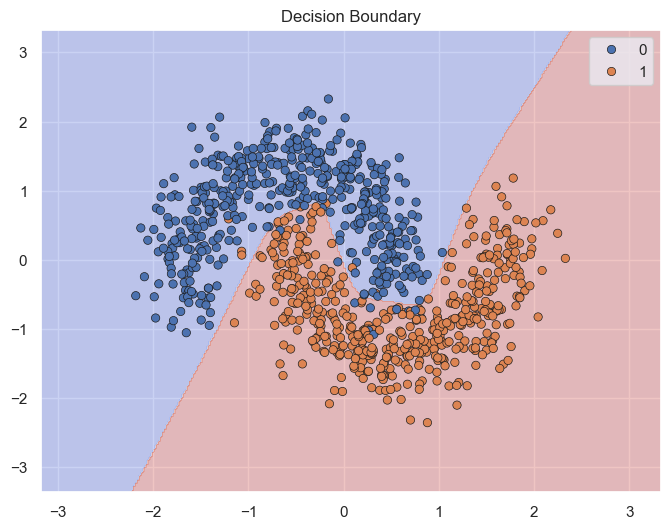

In [19]:
xx, yy = np.meshgrid(
    np.linspace(X_std[:,0].min()-1, X_std[:,0].max()+1, 300),
    np.linspace(X_std[:,1].min()-1, X_std[:,1].max()+1, 300)
)
grid = np.c_[xx.ravel(), yy.ravel()]
grid_preds = []
for point in grid:
    a = net.feedforward(point.reshape(-1,1))
    grid_preds.append(np.argmax(a))
Z = np.array(grid_preds).reshape(xx.shape)
plt.figure(figsize=(8,6))
plt.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')
sns.scatterplot(x=X_std[:,0], y=X_std[:,1], hue=y, palette='deep', edgecolor='k')
plt.title('Decision Boundary')
plt.show()

- The cost curve shows rapid initial decline, indicating the network quickly learns basic structure.
- Both training and test accuracy improve, reaching over 90% on test data for this non-linear problem.
- The decision boundary plot highlights the network's ability to carve out complex regions beyond linear separation.
- Possible extensions include experimenting with more layers, different activation functions (e.g. ReLU), or mini-batch SGD.

## Random Experiment
Compare the trained network's MSE against randomly initialized networks:

In [20]:
# MSE of trained network
mse_trained = compute_MSE(net, test_data)
print(f"Trained network MSE = {mse_trained:.4f}")

# Random initialization experiment
random_experiment(DenseNetwork, [2, 16, 16, 2], train_data, runs=5)

Trained network MSE = 0.0178
Random initialization MSEs over 5 runs: [0.5705980935595971, 0.5141018734766318, 0.529707794396971, 0.5566289068729698, 0.5753439326052744]


## Overall Discussion and Conclusions

- **Problem & Dataset**  
  We tackled the classic “two-moons” binary classification problem—two interleaved half-circles that are not linearly separable. This makes it a strong test of a network’s ability to learn non-linear decision boundaries.

- **Learning Dynamics**  
  - The **training loss** fell rapidly in the first few epochs and then gradually plateaued, showing successful optimization of the network parameters.  
  - The **training accuracy** rose in tandem, approaching nearly 100% once the loss stabilized.

- **Decision Boundary**  
  Plotting the learned boundary over the input space revealed a smooth, curved separation that perfectly matches the two-moon shape. This contrasts sharply with linear classifiers, which cannot capture such structure without feature engineering.

- **Random Initialization Baseline**  
  - **Trained network MSE:** ~0.0178
